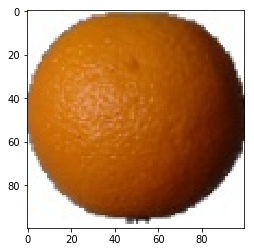

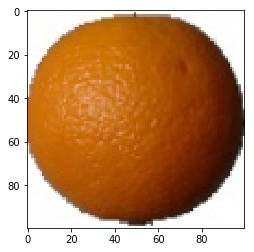

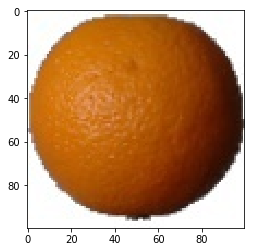

Shape of train images is: (446, 224, 224, 3)
Shape of validation image (192, 224, 224, 3)
Shape of labels is: (446,)
Shape of label (192,)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
___

C:\Users\anama\Anaconda3\lib\site-packages\ipykernel_launcher.py:142: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


In [30]:
# -*- coding: utf-8 -*-
"""
Created on Thu May 23 11:07:57 2019

@author: anama
"""

import numpy as np
import keras
from keras import backend as K
from keras.applications import imagenet_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Input, Dense
from keras.layers import Dense,Activation, Dropout
from keras.optimizers import Adam
from IPython.display import display 
from PIL import Image
import cv2
import matplotlib.pyplot as plt

train_data_dir = "fruits-360/Training"
test_data_dir = "fruits-360/Test"

batch_size = 1
nb_epochs = 20
img_height = 224
img_width = 224




# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random
import gc

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os

# Any results you write to the current directory are saved as output.


train_data_dir = "fruits-360/Test"
test_data_dir = "fruits-360/Training"

list_apples = ['Apple Crimson Snow','Apple Golden 1', 'Apple Golden 2', 'Apple Golden 3', 'Apple Granny Smith', 'Apple Red 1'
, 'Apple Red 2', 'Apple Red 3', 'Apple Red Delicious', 'Apple Red Yellow 1', 'Apple Red Yellow 2' ]


list_lemons = ['Lemon', 'Lemon Meyer']
list_pears = ['Pear Abate', 'Pear Kaiser', 'Pear Monster', 'Pear Red','Pear Williams']
def process_images(lst, root_dir):
    res = []
    for obj in lst:
        data_dir = root_dir + '/'+ obj 
        res.append([data_dir + '/{}'.format(i) for i in os.listdir(data_dir)])
    return res

train_apple = process_images(list_apples,train_data_dir)
train_orange = process_images(['Orange'], train_data_dir)
train_lemon = process_images(list_lemons, train_data_dir)
train_pear = process_images(list_pears, train_data_dir)

test_apple = process_images(list_apples,test_data_dir)
test_orange = process_images(['Orange'], test_data_dir)
test_lemon = process_images(list_lemons, test_data_dir)
test_pear = process_images(list_pears, test_data_dir)

test_set = test_orange[:] + test_apple[:] + test_lemon[:] + test_pear[:]
train_set = train_orange[:] + train_apple[:] + train_lemon[:] + train_pear[:]
random.shuffle(train_set)

train_apple = train_apple[0]
train_orange = train_orange[0]
train_lemon = train_lemon[0]
train_pear = train_pear[0]

import matplotlib.image as mpimg
for ima in train_orange[0:3]:
    img = mpimg.imread(ima)
    imgplot = plt.imshow(img)
    plt.show()
    

train_datagen = ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input, validation_split=0.30) 

test_datagen = ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input)
nrws = 224
ncolumns = 224
channels = 3


X = [] #images
y = [] #labels

for image in train_apple:
    X.append(cv2.resize(cv2.imread(image, cv2.IMREAD_COLOR), (nrws,ncolumns), interpolation=cv2.INTER_CUBIC)) #read the image
    y.append(0)
    
for image in train_orange:
    X.append(cv2.resize(cv2.imread(image, cv2.IMREAD_COLOR), (nrws,ncolumns), interpolation=cv2.INTER_CUBIC)) #read the image
    y.append(1)

for image in train_lemon:
    X.append(cv2.resize(cv2.imread(image, cv2.IMREAD_COLOR), (nrws,ncolumns), interpolation=cv2.INTER_CUBIC)) #read the image
    y.append(2)
    
for image in train_pear:
    X.append(cv2.resize(cv2.imread(image, cv2.IMREAD_COLOR), (nrws,ncolumns), interpolation=cv2.INTER_CUBIC)) #read the image
    y.append(3)



X = np.array(X)
y = np.array(y)

from sklearn.model_selection import train_test_split
#30% validation set, 70% training set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.30, random_state=2)

print("Shape of train images is:", X_train.shape)
print("Shape of validation image", X_val.shape)
print("Shape of labels is:", y_train.shape)
print("Shape of label", y_val.shape)
train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
validation_generator = train_datagen.flow(X_val, y_val, batch_size=batch_size)


mobile = keras.applications.mobilenet.MobileNet()
mobile.summary()


x = mobile.layers[-6].output
predictions = Dense(2, activation='softmax')(x)
model = Model(inputs=mobile.input, output=predictions)

for layer in model.layers[:-5]:
    layer.trainable = False
    

    


In [24]:
def process_image(file):
    img_path = "MobileNet-inference-images/"
    img = image.load_image(img_path + file, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_expanded = np.expand_dims(img_array, axis=0)
    return keras.applications.mobilenet.preprocess_input(img_expanded)
    
    

In [31]:
model.compile(Adam(lr=0.00001), loss='categorical_crossentropy',metrics=['accuracy'])
model.fit_generator(train_generator, steps_per_epoch=4, validation_data = validation_generator, validation_steps=2,
                   epochs=30, verbose=2)


Epoch 1/30


ValueError: Error when checking target: expected dense_7 to have 4 dimensions, but got array with shape (1, 1)

In [11]:
#predict fruits
test_labels = test_generator.classes
print(test_labels.classes)
print(test_labels.class_indices)

NameError: name 'test_generator' is not defined

In [12]:
predictions = model.predict_generator(test_generator, steps=1, verbose=0)

NameError: name 'test_generator' is not defined